<a href="https://colab.research.google.com/github/Seife1/PRODIGY_ML_03/blob/main/Image_Classification_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classification Using Support Vector Machine**

**SVMs**: are a type of supervised machine learning algorithm that can be used for classification and regression tasks.

The SVM algorithm works by finding the `hyperplane` that separates the different classes in the feature space. The key idea behind SVMs is to find the hyperplane that maximizes the margin, which is the distance between the closest points of the different classes. The points that are closest to the hyperplane are called support vectors.

## **Data Overview**

The data is extracted and aggregated from [kaggle](https://www.kaggle.com/c/dogs-vs-cats/data). The training archive contains 25,000 images of dogs and cats.

## **Imports and Load Data**

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import zipfile

# Image package
from PIL import Image
import io
from skimage.transform import resize
from skimage.io import imread

# Machine Learning
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Warnning
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set Kaggle Configuration: To direct Kaggle to the appropriate directory in Drive
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [4]:
!kaggle competitions download -c dogs-vs-cats

In [50]:
# Define the path to your zip file
file_path = '/content/dogs-vs-cats.zip'

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kaggle/DogandCat')

In [51]:
zip_files = ['test1', 'train']

for zip_file in zip_files:
  with zipfile.ZipFile("/content/drive/MyDrive/kaggle/DogandCat/{}.zip".format(zip_file), 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kaggle/DogandCat')
    print("{} unzipped".format(zipfile))

## **Explanatory Data Analysis**
Our next focus will be on understanding, exploring, and analyzing this dataset.

### Data Understanding

In [52]:
TRAIN_DIR = '/content/drive/MyDrive/kaggle/DogandCat/train'
TEST_DIR = '/content/drive/MyDrive/kaggle/DogandCat/test1'

PATHS = [TRAIN_DIR, TEST_DIR]
for PATH in PATHS:
  file_names = os.listdir(PATH)
  print(f"There are {len(file_names)} number of images in directory")

There are 25000 number of images in directory
There are 12500 number of images in directory


In [53]:
# Define an empty directory to separate input features and targets
input_images = []
labels = []

train_dogs_dir = []
train_cats_dir = []

# for category in Categories:
for img in os.listdir(TRAIN_DIR):
  label = img.split('.')[0]
  input_image = os.path.join(TRAIN_DIR, img)

  if label == 'cat':
    train_cats_dir.append(input_image)
  else:
    train_dogs_dir.append(input_image)

  input_images.append(input_image)
  labels.append(label)

dataset = pd.DataFrame({'Input Images': input_images, 'Labels': labels})

In [54]:
dataset.head()

Input Images Labels
0  /content/drive/MyDrive/kaggle/DogandCat/train/...    dog
1  /content/drive/MyDrive/kaggle/DogandCat/train/...    dog
2  /content/drive/MyDrive/kaggle/DogandCat/train/...    dog
3  /content/drive/MyDrive/kaggle/DogandCat/train/...    dog
4  /content/drive/MyDrive/kaggle/DogandCat/train/...    dog

Total data count: 25000
Labels
dog    12500
cat    12500
Name: count, dtype: int64


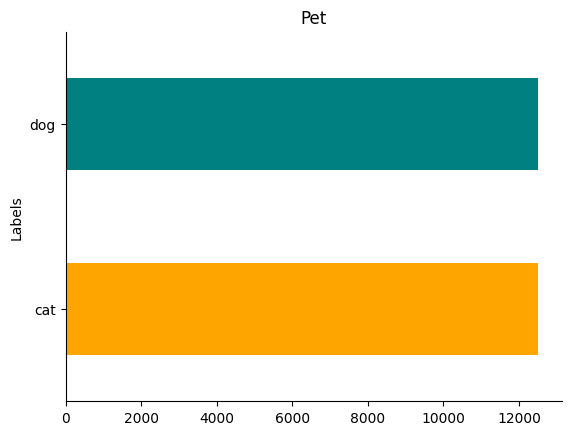

In [55]:
# Total data count and in each target.
print(f"Total data count: {dataset.shape[0]}")
counts = dataset['Labels'].value_counts()
print(counts)

dataset.groupby('Labels').size().plot(
    kind='barh',
    title='Pet',
    color=['orange', 'teal']
)
plt.gca().spines[['top', 'right',]].set_visible(False)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

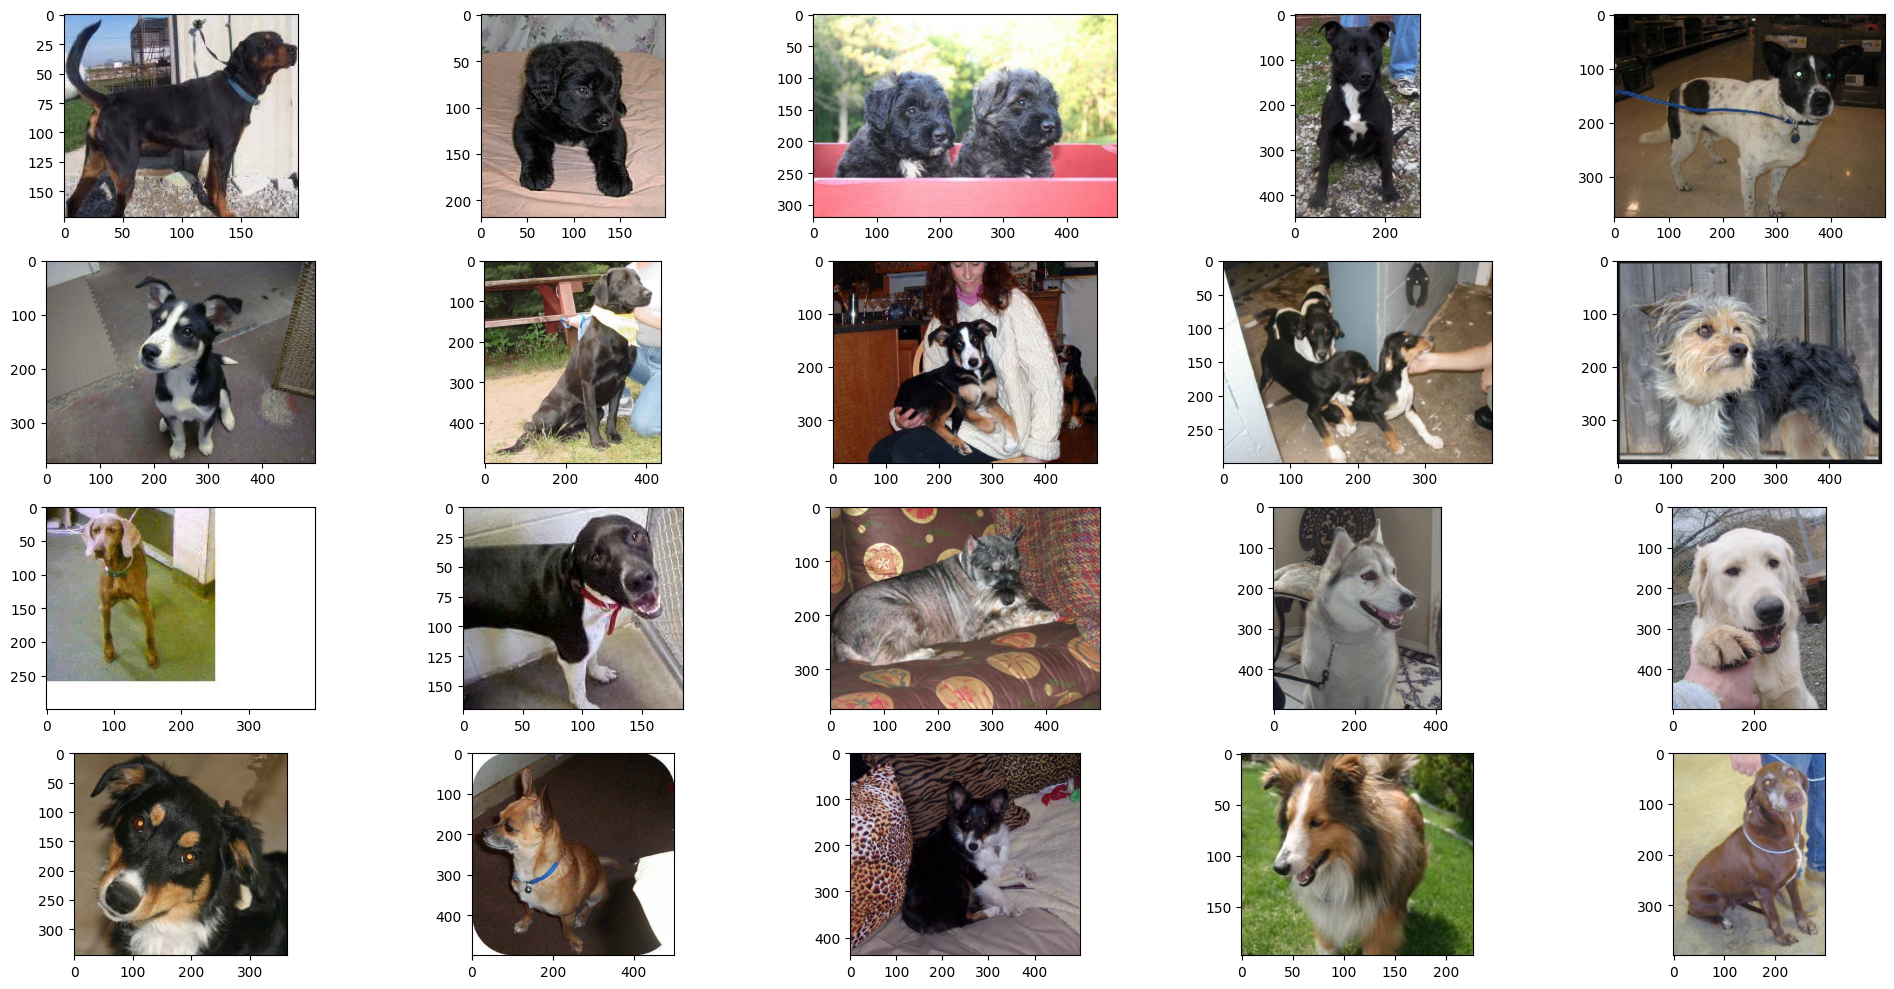

In [56]:
# Display sample images

fig = plt.figure(figsize=(20,10))
rows = 4
cols = 5
axes = []
i=0

for a in range(rows*cols):
  axes.append( fig.add_subplot(rows, cols, a+1) )
  plt.imshow(plt.imread(train_dogs_dir[i]))
  i+=1

fig.tight_layout()
plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

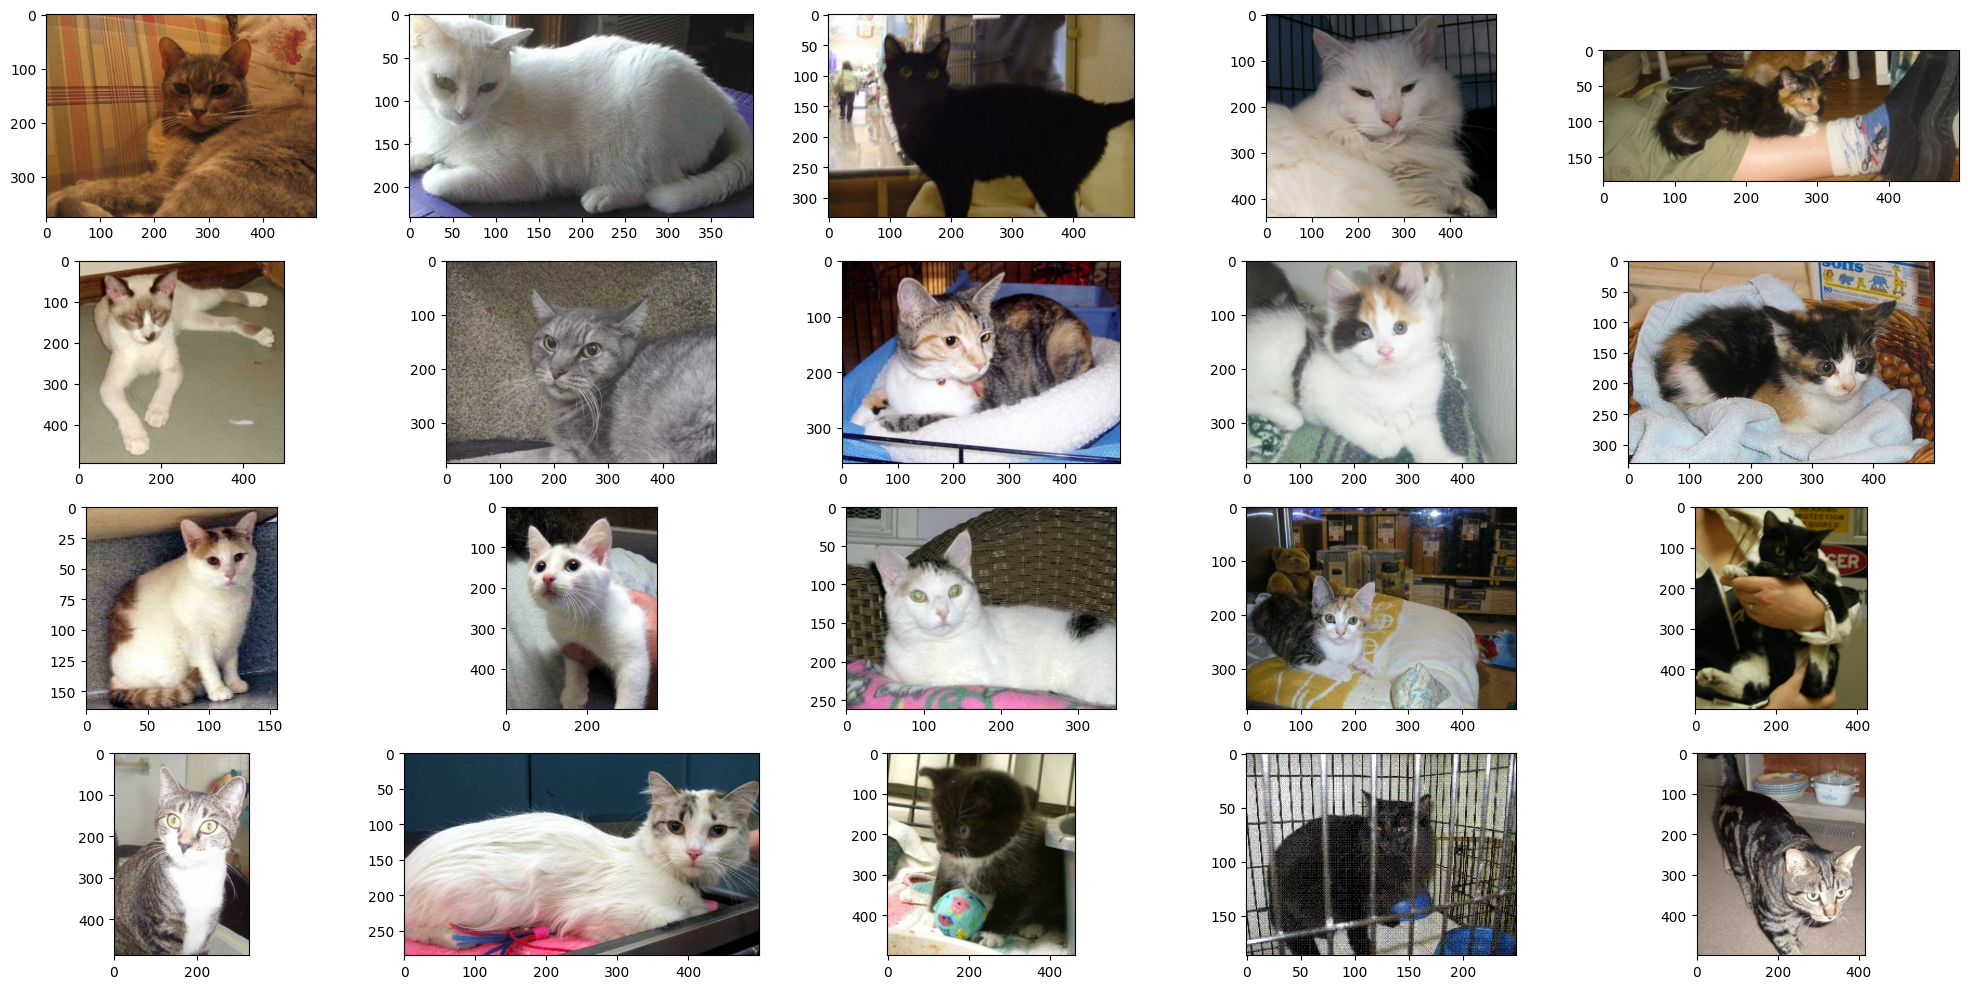

In [57]:
# Display sample cat images

fig = plt.figure(figsize=(20,10))
rows = 4
cols = 5
axes = []
i=0

for a in range(rows*cols):
  axes.append( fig.add_subplot(rows, cols, a+1) )
  plt.imshow(plt.imread(train_cats_dir[i]))
  i+=1

fig.tight_layout()
plt

### Model Training and Evaluation

Here, I will perform image classification using a Support Vector Machine (SVM) with Principal Component Analysis (PCA) for dimensionality reduction.

In [58]:
# Preprocess the image before training
def preprocess_image(img_path):
  img = imread(img_path)

  # Resize the image to a fixed size
  img = resize(img, (124, 124))
  # Flatten image
  img_flat = img.flatten()
  return img_flat

In [59]:
# Mount point in Google Drive
output_dir = '/content/drive/MyDrive/kaggle/DogandCat/preprocessed_batches/'
os.makedirs(output_dir, exist_ok=True)

# Shuffle the dataset to ensure class diversity across batches
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Batch size
batch_size = 500
y = dataset['Labels']

for i in range(0, len(dataset), batch_size):
    X = []
    batch_images = dataset['Input Images'][i:i + batch_size]

    for img_path in batch_images:
        X.append(preprocess_image(img_path))

    # Convert the list to a NumPy array
    X_np = np.array(X)

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X_np)

    pca = PCA(n_components=100)
    X_pca = pca.fit_transform(scaled_data)

    # Save the preprocessed batch to Google Drive
    np.save(f"{output_dir}batch_{i // batch_size}.npy", X_pca)
    np.save(f"{output_dir}labels_batch_{i // batch_size}.npy", y[i:i + batch_size])

    # Clear memory
    del X, X_pca
    print(f"Processed and saved batch {i // batch_size + 1}")

Processed and saved batch 1
Processed and saved batch 2
Processed and saved batch 3
Processed and saved batch 4
Processed and saved batch 5
Processed and saved batch 6
Processed and saved batch 7
Processed and saved batch 8
Processed and saved batch 9
Processed and saved batch 10
Processed and saved batch 11
Processed and saved batch 12
Processed and saved batch 13
Processed and saved batch 14
Processed and saved batch 15
Processed and saved batch 16
Processed and saved batch 17
Processed and saved batch 18
Processed and saved batch 19
Processed and saved batch 20
Processed and saved batch 21
Processed and saved batch 22
Processed and saved batch 23
Processed and saved batch 24
Processed and saved batch 25
Processed and saved batch 26
Processed and saved batch 27
Processed and saved batch 28
Processed and saved batch 29
Processed and saved batch 30
Processed and saved batch 31
Processed and saved batch 32
Processed and saved batch 33
Processed and saved batch 34
Processed and saved bat

**Principal Component Analysis (PCA)** for dimensionality reduction.

PCA allows to keep only the top components that capture the majority of the variance, allowing for more efficient processing.

SVM algorithms, which based on distance metrics, often have higher computational complexity in high-dimensional spaces.

By reducing the number of features, PCA decreases the time and memory required for computations.

In [60]:
from sklearn.pipeline import Pipeline

num_batches = len(dataset) // batch_size

# Perform training on each batch individually and average the model parameters
# best_params_list = []

for i in range(num_batches):
    # Load the preprocessed images and labels from Google Drive
    X_np = np.load(f"{output_dir}batch_{i}.npy")
    y_np = np.load(f"{output_dir}labels_batch_{i}.npy", allow_pickle=True)

    # Check and print classes in each batch
    print(f"Classes in batch {i+1}: {np.unique(y_np)}")

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

    # Creating a support vector classifier
    model = svm.SVC(kernel='rbf', probability=True)
    # Fit the grid search to the training data
    model.fit(X_train, y_train)

Classes in batch 1: ['cat' 'dog']
Classes in batch 2: ['cat' 'dog']
Classes in batch 3: ['cat' 'dog']
Classes in batch 4: ['cat' 'dog']
Classes in batch 5: ['cat' 'dog']
Classes in batch 6: ['cat' 'dog']
Classes in batch 7: ['cat' 'dog']
Classes in batch 8: ['cat' 'dog']
Classes in batch 9: ['cat' 'dog']
Classes in batch 10: ['cat' 'dog']
Classes in batch 11: ['cat' 'dog']
Classes in batch 12: ['cat' 'dog']
Classes in batch 13: ['cat' 'dog']
Classes in batch 14: ['cat' 'dog']
Classes in batch 15: ['cat' 'dog']
Classes in batch 16: ['cat' 'dog']
Classes in batch 17: ['cat' 'dog']
Classes in batch 18: ['cat' 'dog']
Classes in batch 19: ['cat' 'dog']
Classes in batch 20: ['cat' 'dog']
Classes in batch 21: ['cat' 'dog']
Classes in batch 22: ['cat' 'dog']
Classes in batch 23: ['cat' 'dog']
Classes in batch 24: ['cat' 'dog']
Classes in batch 25: ['cat' 'dog']
Classes in batch 26: ['cat' 'dog']
Classes in batch 27: ['cat' 'dog']
Classes in batch 28: ['cat' 'dog']
Classes in batch 29: ['cat' '

In [61]:
print(X_train.shape)

(400, 100)


**Next**: I evaluate the performance of the SVM model on unseen data. This helps me to ensure that the model generalizes well and is not overfitting to the training data

**Model Evaluation**

Now the model is tested using testing data

In [62]:
# Testing the model using the testing data
y_pred = model.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred, target_names=['cat', 'dog']))

              precision    recall  f1-score   support

         cat       0.67      0.61      0.64        57
         dog       0.54      0.60      0.57        43

    accuracy                           0.61       100
   macro avg       0.61      0.61      0.61       100
weighted avg       0.62      0.61      0.61       100



The model achieved an overall accuracy of 61%. The class 'cat' performs better than 'dog' in terms of precision, f1-score, and support, though both classes have similar recall values. The model tends to perform better at identifying 'cats' compared to 'dogs'.

In [63]:
# Saving the model
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

In [64]:
# Check if the file exists in the current directory
if os.path.exists('model.pkl'):
    print("File 'model.pkl' exists in the current directory.")

File 'model.pkl' exists in the current directory.
